## Tạo class Convolution để định nghĩa lớp CONV2D
Class Convolution sẽ nhận các tham số:
- input shape: Là một mảng 2 phần tử height và width mô tả kích thước của ảnh input
- filter_size: Kích thước kernel cần dùng
- num_filter: Số lớp chồng feature map

## 1. Công Thức Chuỗi (Chain Rule)
 Gradient tổng Loss (L) theo một trọng số filter cụ thể (W_{m,n}) là tổng ảnh hưởng qua mọi điểm đầu ra O_{i,j}:
$$
\frac{\partial L}{\partial W_{m,n}} = \sum_{i,j} \frac{\partial L}{\partial O_{i,j}} \cdot \frac{\partial O_{i,j}}{\partial W_{m,n}}
$$

## 2. Gradient Cục Bộ (Local Gradient)
Từ công thức lan truyền xuôi (Forward Pass):
$$
O_{i,j} = \sum_{m',n'} X_{i+m', j+n'} \cdot W_{m',n'}
$$
Ta có đạo hàm riêng của O_{i,j} theo W_{m,n} chính là giá trị Input tương ứng:
$$
\frac{\partial O_{i,j}}{\partial W_{m,n}} = X_{i+m, j+n}
$$

## 3. Nhận Dạng Phép Toán (Tương quan chéo)
Thay kết quả vào Chain Rule, ta được công thức tính Gradient của Filter:
$$
\frac{\partial L}{\partial W_{m,n}} = \sum_{i,j} X_{i+m, j+n} \cdot \frac{\partial L}{\partial O_{i,j}}
$$
Công thức này chính là phép **Tương quan chéo (Cross-Correlation)** giữa Input (X) và Gradient đầu ra $(\frac{\partial L}{\partial O})$.

In [1]:
import numpy as np
from scipy.signal import correlate2d

class Convolution:

    def __init__(self, input_shape, filter_size, num_filters):
        input_height, input_width = input_shape
        self.num_filters = num_filters
        self.input_shape = input_shape

        self.filter_shape = (num_filters, filter_size, filter_size)
        self.output_shape = (num_filters, input_height, input_width)

        self.filters = np.random.randn(*self.filter_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input_data):
        self.input_data = input_data
        output = np.zeros(self.output_shape)
        for i in range(self.num_filters):
            # Sử dụng mode = same để đảm bảo không bị mất pixel sau khi thực hiện tích chập (zero - pad)
            output[i] = correlate2d(self.input_data, self.filters[i], mode="same")

        # Áp dụng Relu vào đầu ra
        output = np.maximum(output, 0)
        return output

    def backward(self, dL_out, lr):
        dL_input = np.zeros_like(self.input_data)
        dL_filters = np.zeros_like(self.filters)

        for i in range(self.num_filters):
                # Tính gradient cho filter
                dL_filters[i] = correlate2d(self.input_data, dL_out[i],mode="valid")

                # Tính gradient cho input để backprop
                dL_input += correlate2d(dL_out[i],self.filters[i], mode="same")

        # Update tham số
        self.filters -= lr * dL_filters
        self.biases -= lr * dL_out

        # trả gradient input nếu cần lan truyền ngược
        return dL_input


## Gradient Lớp Max Pooling

Max Pooling không có tham số để học, chỉ tính gradient của Loss theo Input (L/X) để truyền ngược.

1. Công thức tổng quát:
Gradient của Loss (L) theo một phần tử Input (X_{c, i, j}) được tính bằng:
$$
\frac{\partial L}{\partial \mathbf{X}_{c, i, j}} = \begin{cases} \frac{\partial L}{\partial \mathbf{O}_{c, i', j'}} & \text{nếu } \mathbf{X}_{c, i, j} \text{ là } \max \text{ trong cửa sổ } (i', j') \\ 0 & \text{trong trường hợp còn lại} \end{cases}
$$

2. Diễn giải theo hoạt động (Sử dụng Masking):
Gradient $(\frac{\partial L}{\partial \mathbf{O}})$ chỉ được nhân với mặt nạ (mask) của các vị trí winning.
$$
\frac{\partial L}{\partial \mathbf{X}_{\text{patch}}} = \frac{\partial L}{\partial \mathbf{O}_{\text{cell}}} \times \mathbf{Mask}
$$
Trong đó:
$$\mathbf{Mask}_{\text{patch}} = \begin{cases} 1 & \text{nếu } \mathbf{X}_{\text{patch}} \text{ là } \max(\mathbf{X}_{\text{patch}}) \\ 0 & \text{ngược lại} \end{cases}$$

In [2]:
class MaxPool:
    def __init__(self, pool_size):
        self.pool_size = pool_size
    def forward(self, input_data):
        self.input_data = input_data
        self.num_channels, self.input_height, self.input_width = input_data.shape
        # Chỗ này chia cho pool size vì sau khi max pool đầu ra sẽ bị downsample đi ngần nấy lần
        self.output_height = self.input_height // self.pool_size
        self.output_width = self.input_width // self.pool_size

        self.output = np.zeros((self.num_channels, self.output_height, self.output_width))

        # lặp qua các channel
        for c in range(self.num_channels):
            # lặp theo height
            for i in range(self.output_height):
                # lặp theo width
                for j in range(self.output_width):
                    start_i = i * self.pool_size
                    start_j = j * self.pool_size
                    end_i = start_i + self.pool_size
                    end_j = start_j + self.pool_size

                    # Sau khi xác lập được các toạ độ của patch cần thực hiện maxpool, tạo patch
                    patch = input_data[c, start_i:end_i, start_j:end_j]

                    # Chọn winning pixel
                    self.output[c, i, j] = np.max(patch)

        return self.output
    def backward(self, dL_dout, lr):
        dL_dinput = np.zeros_like(self.input_data)

        for c in range(self.num_channels):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    start_i = i * self.pool_size
                    start_j = j * self.pool_size

                    end_i = start_i + self.pool_size
                    end_j = start_j + self.pool_size
                    patch = self.input_data[c, start_i:end_i, start_j:end_j]

                    mask = patch == np.max(patch)

                    dL_dinput[c,start_i:end_i, start_j:end_j] = dL_dout[c, i, j] * mask

        return dL_dinput

## Lớp Fully Connected (Dense) Backpropagation

 1. Tính Gradient Loss theo Pre-Activation (Sử dụng Softmax)
 Đây là tín hiệu lỗi sau khi đi qua đạo hàm của hàm kích hoạt (Softmax).
 Công thức sử dụng đạo hàm Softmax trên vector (Jaccobian matrix):
$$
\mathbf{\delta} = \frac{\partial L}{\partial \mathbf{Z}} = \frac{\partial L}{\partial \mathbf{Y}} \cdot \frac{\partial \mathbf{Y}}{\partial \mathbf{Z}}
$$
 Với $\frac{\partial \mathbf{Y}}{\partial \mathbf{Z}}$ là ma trận Jacobian của Softmax.

 2. Gradient theo Trọng số (W)
 Cập nhật Trọng số W:
$$
\frac{\partial L}{\partial \mathbf{W}} = \mathbf{\delta} \cdot \mathbf{X}^{T}
$$

3. Gradient theo Bias (B)
 Cập nhật Bias B:
$$
\frac{\partial L}{\partial \mathbf{B}} = \mathbf{\delta}
$$

4. Gradient theo Input (X)
Gradient truyền về lớp trước (X là input đã được làm phẳng):
$$
\frac{\partial L}{\partial \mathbf{X}} = \mathbf{W}^{T} \cdot \mathbf{\delta}
$$


In [3]:
class Fully_Connected:

    def __init__(self, input_size, output_size=10):
        self.input_size = input_size # Size của input, số này phải được tính bằng map * chiều cao * chiều rộng ảnh
        self.output_size = output_size # Size của output, chọn 10 vì có 10 chữ số 0 - 9
        self.weights = np.random.randn(output_size, self.input_size)
        self.biases = np.random.rand(output_size, 1)
    def softmax(self, z):
        # Code chống numerical instability
        shifted_z = z - np.max(z)
        exp_values = np.exp(shifted_z)
        sum_exp_values = np.sum(exp_values, axis=0)
        log_sum_exp = np.log(sum_exp_values)

        # Tính softmax
        probabilities = exp_values / sum_exp_values

        return probabilities

    def softmax_derivative(self, s):
        return np.diagflat(s) - np.dot(s, s.T)

    def forward(self, input_data):
        self.input_data = input_data
        flattened_input = input_data.flatten().reshape(1, -1)
        self.z = np.dot(self.weights, flattened_input.T) + self.biases
        self.output = self.softmax(self.z)
        return self.output
    def backward(self, dL_out, lr):
        dL_y = np.dot(self.softmax_derivative(self.output), dL_out)
        dL_w = np.dot(dL_y, self.input_data.flatten().reshape(1, -1))
        dL_db = dL_y

        dL_input = np.dot(self.weights.T, dL_y)
        dL_input = dL_input.reshape(self.input_data.shape)

        self.weights -= lr * dL_w
        self.biases -= lr * dL_db

        return dL_input

## Hàm Mất Mát Cross-Entropy (CCE Loss)

Công thức tính Loss trung bình (Mean Cross-Entropy Loss) cho nhiều mẫu (num_samples):
$$
L = - \frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})
$$

Trong đó:
* $N$: Tổng số mẫu (num_samples).
* $C$: Tổng số lớp (classes).
* $y_{i,c}$: Nhãn thực tế (targets) cho mẫu thứ $i$và lớp thứ$c$ (thường là 1 nếu đúng, 0 nếu sai).
* $\hat{y}_{i,c}$: Xác suất dự đoán (predictions) cho mẫu thứ i và lớp thứ c (sau hàm Softmax).
* **Ghi chú code:** Hàm `np.clip` được dùng để tránh $\log(0)$ (numerical instability).

---

## Gradient của Cross-Entropy Loss
 Gradient của Loss theo xác suất dự đoán ($\hat{y}$), sau khi đã tính đạo hàm qua hàm Softmax (thường là bước đầu tiên trong backward pass):
$$
\frac{\partial L}{\partial \hat{\mathbf{Y}}} = - \frac{1}{N} \cdot \frac{\mathbf{Y}}{\hat{\mathbf{Y}}}
$$
 Hoặc đối với từng phần tử:
$$
\frac{\partial L}{\partial \hat{y}_{i,c}} = - \frac{1}{N} \cdot \frac{y_{i,c}}{\hat{y}_{i,c}}
$$


In [4]:
def cross_entropy_loss(predictions, targets):

    num_samples = 10

    # Avoid numerical instability by adding a small epsilon value
    epsilon = 1e-7
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    loss = -np.sum(targets * np.log(predictions)) / num_samples
    return loss

def cross_entropy_loss_gradient(actual_labels, predicted_probs):
    num_samples = actual_labels.shape[0]
    gradient = -actual_labels / (predicted_probs + 1e-7) / num_samples

    return gradient

def train_network(X, y, conv, pool, full, lr=0.01, epochs=200):
    for epoch in range(epochs):
        total_loss = 0.0
        correct_predictions = 0

        for i in range(len(X)):
            # Forward pass
            conv_out = conv.forward(X[i])
            pool_out = pool.forward(conv_out)
            full_out = full.forward(pool_out)
            loss = cross_entropy_loss(full_out.flatten(), y[i])
            total_loss += loss

            # Converting to One-Hot encoding
            one_hot_pred = np.zeros_like(full_out)
            one_hot_pred[np.argmax(full_out)] = 1
            one_hot_pred = one_hot_pred.flatten()

            num_pred = np.argmax(one_hot_pred)
            num_y = np.argmax(y[i])

            if num_pred == num_y:
                correct_predictions += 1
            # Backward pass
            gradient = cross_entropy_loss_gradient(y[i], full_out.flatten()).reshape((-1, 1))
            full_back = full.backward(gradient, lr)
            pool_back = pool.backward(full_back, lr)
            conv_back = conv.backward(pool_back, lr)

        # Print epoch statistics
        average_loss = total_loss / len(X)
        accuracy = correct_predictions / len(X_train) * 100.0
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {average_loss:.4f} - Accuracy: {accuracy:.2f}%")

def predict(input_sample, conv, pool, full):
    # Forward pass through Convolution and pooling
    conv_out = conv.forward(input_sample)
    pool_out = pool.forward(conv_out)
    # Flattening
    flattened_output = pool_out.flatten()
    # Forward pass through fully connected layer
    predictions = full.forward(flattened_output)
    return predictions



## Tải dữ liệu MNIST

 1. Tải và Chia Dữ liệu
Tải tập dữ liệu MNIST: Lấy ma trận ảnh (X) và nhãn số nguyên (y).
 Phân chia:
 - Tập huấn luyện (X_train, y_train): 5000 mẫu đầu tiên.
 - Tập kiểm tra (X_test, y_test): 5000 mẫu tiếp theo.

 2. Chuẩn hóa (Normalization): Đưa giá trị pixel từ [0, 255] về [0.0, 1.0].
 Giúp tối ưu hóa hội tụ nhanh hơn và ổn định hơn. Thực hiện: Chia X_train và X_test cho 255.0.

 3. Mã hóa One-Hot (One-Hot Encoding): Chuyển nhãn số nguyên (0-9) thành vector nhị phân 10 chiều, đây là yêu cầu bắt buộc khi sử dụng hàm Softmax và Cross-Entropy Loss trong lớp đầu ra.
 Thực hiện: Sử dụng to_categorical() cho y_train và y_test.


In [6]:
import tensorflow.keras as keras
import numpy as np

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
X_train = train_images[:5000] / 255.0
y_train = train_labels[:5000]

X_test = train_images[5000:10000] / 255.0
y_test = train_labels[5000:10000]

X_train.shape
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_test[0]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

## Huấn luyện mạng CNN với 5 feature maps

In [16]:
conv = Convolution([28,28], 2, 5)
pool = MaxPool(2)
full = Fully_Connected(5*14*14,10)
train_network(X_train, y_train, conv, pool, full, epochs=10)


Epoch 1/10 - Loss: 0.7690 - Accuracy: 17.70%
Epoch 2/10 - Loss: 0.5848 - Accuracy: 33.30%
Epoch 3/10 - Loss: 0.4588 - Accuracy: 46.86%
Epoch 4/10 - Loss: 0.3860 - Accuracy: 55.24%
Epoch 5/10 - Loss: 0.3436 - Accuracy: 60.90%
Epoch 6/10 - Loss: 0.3178 - Accuracy: 64.62%
Epoch 7/10 - Loss: 0.3005 - Accuracy: 67.60%
Epoch 8/10 - Loss: 0.2881 - Accuracy: 69.66%
Epoch 9/10 - Loss: 0.2790 - Accuracy: 71.18%
Epoch 10/10 - Loss: 0.2718 - Accuracy: 72.08%


Kích thước ảnh: (28, 28)
Nhãn (Label) của ảnh: 3


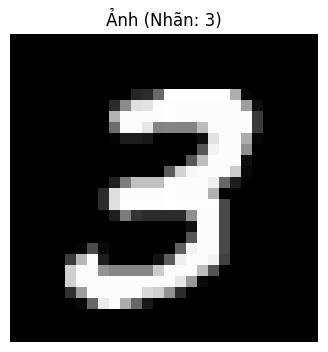

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
index = 7
image = train_images[index]

print(f"Kích thước ảnh: {image.shape}")
print(f"Nhãn (Label) của ảnh: {train_labels[index]}")

plt.figure(figsize=(4, 4))
plt.imshow(image, cmap="gray")
plt.title(f"Ảnh (Nhãn: {train_labels[index]})")
plt.axis('off')
plt.show()

In [21]:
# Code để thử mô hình
np.argmax(predict(image, conv, pool, full))

np.int64(3)

## Lưu mô hình vào file pkl để dùng sau

In [26]:
import os
os.listdir()

import pickle
import os

# 1. Tập hợp các thành phần của mô hình vào một dictionary (hoặc list)
model_components = {
    'conv_layer': conv,
    'pool_layer': pool, # MaxPool không có tham số học, nhưng vẫn lưu instance để tái tạo cấu trúc
    'fc_layer': full
}

# 2. Định nghĩa tên file
model_filename = 'cnn_model.pkl'

# 3. Lưu trữ bằng pickle
try:
    with open(model_filename, 'wb') as file:
        pickle.dump(model_components, file)
    print(f"Mô hình đã được lưu thành công vào file: {model_filename}")
except Exception as e:
    print(f"Lỗi khi lưu mô hình: {e}")

Mô hình đã được lưu thành công vào file: sample_data/cnn_model.pkl


## Code để load mô hình

Lưu ý: Khi load lại mô hình cần load cả định nghĩa các class bên trên kia

Mô hình đã được tải lại thành công.
Kích thước bộ lọc lớp CONV: (5, 2, 2)
Kích thước trọng số lớp FC: (10, 980)
Kích thước ảnh: (28, 28)
Nhãn (Label) của ảnh: 3


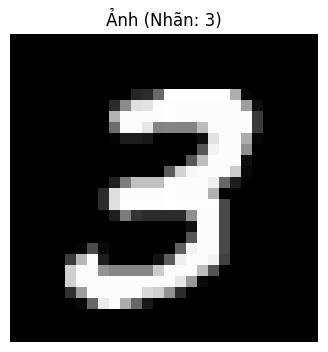

Dự đoán: 3


In [3]:
# Đoạn đầu này là để tái định nghĩa các lớp và hàm

import numpy as np
from scipy.signal import correlate2d

class Convolution:

    def __init__(self, input_shape, filter_size, num_filters):
        input_height, input_width = input_shape
        self.num_filters = num_filters
        self.input_shape = input_shape

        self.filter_shape = (num_filters, filter_size, filter_size)
        self.output_shape = (num_filters, input_height, input_width)

        self.filters = np.random.randn(*self.filter_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input_data):
        self.input_data = input_data
        output = np.zeros(self.output_shape)
        for i in range(self.num_filters):
            output[i] = correlate2d(self.input_data, self.filters[i], mode="same")
        output = np.maximum(output, 0)
        return output

    def backward(self, dL_out, lr):
        dL_input = np.zeros_like(self.input_data)
        dL_filters = np.zeros_like(self.filters)

        for i in range(self.num_filters):
                dL_filters[i] = correlate2d(self.input_data, dL_out[i],mode="valid")
                dL_input += correlate2d(dL_out[i],self.filters[i], mode="same")
        self.filters -= lr * dL_filters
        self.biases -= lr * dL_out
        return dL_input

class MaxPool:
    def __init__(self, pool_size):
        self.pool_size = pool_size
    def forward(self, input_data):
        self.input_data = input_data
        self.num_channels, self.input_height, self.input_width = input_data.shape
        self.output_height = self.input_height // self.pool_size
        self.output_width = self.input_width // self.pool_size

        self.output = np.zeros((self.num_channels, self.output_height, self.output_width))

        for c in range(self.num_channels):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    start_i = i * self.pool_size
                    start_j = j * self.pool_size
                    end_i = start_i + self.pool_size
                    end_j = start_j + self.pool_size
                    patch = input_data[c, start_i:end_i, start_j:end_j]
                    self.output[c, i, j] = np.max(patch)

        return self.output
    def backward(self, dL_dout, lr):
        dL_dinput = np.zeros_like(self.input_data)

        for c in range(self.num_channels):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    start_i = i * self.pool_size
                    start_j = j * self.pool_size

                    end_i = start_i + self.pool_size
                    end_j = start_j + self.pool_size
                    patch = self.input_data[c, start_i:end_i, start_j:end_j]

                    mask = patch == np.max(patch)

                    dL_dinput[c,start_i:end_i, start_j:end_j] = dL_dout[c, i, j] * mask

        return dL_dinput
class Fully_Connected:

    def __init__(self, input_size, output_size=10):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(output_size, self.input_size)
        self.biases = np.random.rand(output_size, 1)
    def softmax(self, z):
        shifted_z = z - np.max(z)
        exp_values = np.exp(shifted_z)
        sum_exp_values = np.sum(exp_values, axis=0)
        log_sum_exp = np.log(sum_exp_values)
        probabilities = exp_values / sum_exp_values
        return probabilities

    def softmax_derivative(self, s):
        return np.diagflat(s) - np.dot(s, s.T)

    def forward(self, input_data):
        self.input_data = input_data
        flattened_input = input_data.flatten().reshape(1, -1)
        self.z = np.dot(self.weights, flattened_input.T) + self.biases
        self.output = self.softmax(self.z)
        return self.output
    def backward(self, dL_out, lr):
        dL_y = np.dot(self.softmax_derivative(self.output), dL_out)
        dL_w = np.dot(dL_y, self.input_data.flatten().reshape(1, -1))
        dL_db = dL_y
        dL_input = np.dot(self.weights.T, dL_y)
        dL_input = dL_input.reshape(self.input_data.shape)
        self.weights -= lr * dL_w
        self.biases -= lr * dL_db

        return dL_input

def cross_entropy_loss(predictions, targets):

    num_samples = 10
    epsilon = 1e-7
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    loss = -np.sum(targets * np.log(predictions)) / num_samples
    return loss

def cross_entropy_loss_gradient(actual_labels, predicted_probs):
    num_samples = actual_labels.shape[0]
    gradient = -actual_labels / (predicted_probs + 1e-7) / num_samples

    return gradient

def train_network(X, y, conv, pool, full, lr=0.01, epochs=200):
    for epoch in range(epochs):
        total_loss = 0.0
        correct_predictions = 0

        for i in range(len(X)):
            conv_out = conv.forward(X[i])
            pool_out = pool.forward(conv_out)
            full_out = full.forward(pool_out)
            loss = cross_entropy_loss(full_out.flatten(), y[i])
            total_loss += loss

            one_hot_pred = np.zeros_like(full_out)
            one_hot_pred[np.argmax(full_out)] = 1
            one_hot_pred = one_hot_pred.flatten()

            num_pred = np.argmax(one_hot_pred)
            num_y = np.argmax(y[i])

            if num_pred == num_y:
                correct_predictions += 1
            gradient = cross_entropy_loss_gradient(y[i], full_out.flatten()).reshape((-1, 1))
            full_back = full.backward(gradient, lr)
            pool_back = pool.backward(full_back, lr)
            conv_back = conv.backward(pool_back, lr)

        average_loss = total_loss / len(X)
        accuracy = correct_predictions / len(X_train) * 100.0
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {average_loss:.4f} - Accuracy: {accuracy:.2f}%")

def predict(input_sample, conv, pool, full):
    conv_out = conv.forward(input_sample)
    pool_out = pool.forward(conv_out)
    flattened_output = pool_out.flatten()
    predictions = full.forward(flattened_output)
    return predictions



# Từ đây là để load mô hình
import pickle

# 1. Tên file cần tải
model_filename = 'cnn_model.pkl'

# 2. Tải mô hình bằng pickle
try:
    with open(model_filename, 'rb') as file:
        loaded_model = pickle.load(file)

    # 3. Gán lại các thành phần đã tải vào các biến
    loaded_conv = loaded_model['conv_layer']
    loaded_pool = loaded_model['pool_layer']
    loaded_full = loaded_model['fc_layer']

    print("Mô hình đã được tải lại thành công.")
    print(f"Kích thước bộ lọc lớp CONV: {loaded_conv.filters.shape}")
    print(f"Kích thước trọng số lớp FC: {loaded_full.weights.shape}")

    # 4. Kiểm tra dự đoán với mô hình đã tải

    import numpy as np
    import matplotlib.pyplot as plt
    from tensorflow.keras.datasets import mnist

    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    index = 7
    image = train_images[index]

    print(f"Kích thước ảnh: {image.shape}")
    print(f"Nhãn (Label) của ảnh: {train_labels[index]}")

    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap="gray")
    plt.title(f"Ảnh (Nhãn: {train_labels[index]})")
    plt.axis('off')
    plt.show()

    print("Dự đoán: " + str(np.argmax(predict(image, loaded_conv, loaded_pool, loaded_full))))

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file mô hình '{model_filename}'.")
except Exception as e:
    print(f"Lỗi khi tải mô hình: {e}")